Here is an example to illustrate how the `forget`, `input`, and `output` gates in an LSTM work. We'll take the example of a sequence of words in a sentence, where the LSTM is used for part-of-speech tagging. The LSTM must remember relevant information (such as the context of the sentence) and forget irrelevant details to make accurate predictions.

# Forget Gate
The `forget` gate decides which information from the cell state should be thrown away or kept. This gate uses a `sigmoid` function to produce values between 0 and 1, where 0 means "completely forget" and 1 means "completely retain".
### Example:
Sentence: "The quick brown fox jumps over the lazy dog."

*   Input Sequence: ["The", "quick", "brown", "fox", "jumps", "over", "the",
"lazy", "dog"]
*   Current Word: "fox"
*   Previous Words: ["The", "quick", "brown"]
*  Forget Gate Example:
  *  Forget information about "The" and "quick" as they are less relevant to
predicting the part of speech of "fox".
  *  Retain some information about "brown" since it might help in understanding "fox".



# Input Gate
The input gate decides which new information should be added to the cell state. It also uses a sigmoid function to filter values and a tanh function to create new candidate values.

### Example:
Sentence: "The quick brown fox jumps over the lazy dog."
* Input Sequence: ["The", "quick", "brown", "fox", "jumps", "over", "the", "lazy", "dog"]
* Current Word: "fox"
* New Information Example:
  * Add information about "fox" being a noun.
  * Add context that "fox" is an animal, which might be relevant for future predictions.

# Output Gate
The output gate decides which part of the cell state should be output as the hidden state. This hidden state is used for the next time step and for making predictions.

### Example:
Sentence: "The quick brown fox jumps over the lazy dog."
* Input Sequence: ["The", "quick", "brown", "fox", "jumps", "over", "the", "lazy", "dog"]
* Current Word: "fox"
* Output Information Example:
  * Output relevant information to predict that the next word "jumps" is likely a verb.
  * Maintain information that the subject "fox" is a noun.


Now we use a more detailed example with numerical values to show how these gates work in the code:

In [1]:
import torch
import torch.nn as nn
import numpy as np


In [2]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size * 4)
        self.hidden_state = torch.zeros(1, hidden_size)
        self.cell_state = torch.zeros(1, hidden_size)

    def forward(self, x):
        combined = torch.cat((x, self.hidden_state), 1)
        gates = self.i2h(combined)
        forget_gate, input_gate, output_gate, candidate_values = gates.chunk(4, 1)

        forget_gate = torch.sigmoid(forget_gate)
        input_gate = torch.sigmoid(input_gate)
        output_gate = torch.sigmoid(output_gate)
        candidate_values = torch.tanh(candidate_values)

        self.cell_state = self.cell_state * forget_gate + input_gate * candidate_values
        self.hidden_state = output_gate * torch.tanh(self.cell_state)

        return self.hidden_state, self.cell_state

# Initialize LSTM Cell
input_size = 5
hidden_size = 3
lstm_cell = LSTMCell(input_size, hidden_size)


Simulating One Time Step:

In [3]:
# Example input vector (one-hot encoded words or word embeddings)
input_vector = torch.randn(1, input_size)

# Forward pass through the LSTM cell
hidden_state, cell_state = lstm_cell(input_vector)

print("Hidden State:\n", hidden_state)
print("Cell State:\n", cell_state)


Hidden State:
 tensor([[-0.1606,  0.0099, -0.0613]], grad_fn=<MulBackward0>)
Cell State:
 tensor([[-0.5996,  0.0169, -0.1663]], grad_fn=<AddBackward0>)


Here is an example of what happens in each gate:

1. Forget Gate:
  * Previous cell state: [0.5, 0.1, -0.3]
  * Forget gate output (after sigmoid): [0.1, 0.9, 0.5]
  * New cell state (forget operation): [0.5 * 0.1, 0.1 * 0.9, -0.3 * 0.5] = [0.05, 0.09, -0.15]
2. Input Gate:

  * Candidate values (after tanh): [0.2, -0.1, 0.4]
  * Input gate output (after sigmoid): [0.8, 0.3, 0.6]
  * New cell state (input operation): [0.05 + 0.8 * 0.2, 0.09 + 0.3 * (-0.1), -0.15 + 0.6 * 0.4] = [0.21, 0.06, 0.09]
3. Output Gate:

  * Output gate output (after sigmoid): [0.5, 0.9, 0.7]
  * New hidden state: output_gate * tanh(new_cell_state) = [0.5 * tanh(0.21), 0.9 * tanh(0.06), 0.7 * tanh(0.09)] = [0.5 * 0.21, 0.9 * 0.06, 0.7 * 0.09] = [0.105, 0.054, 0.063]

  Let's visualize them!

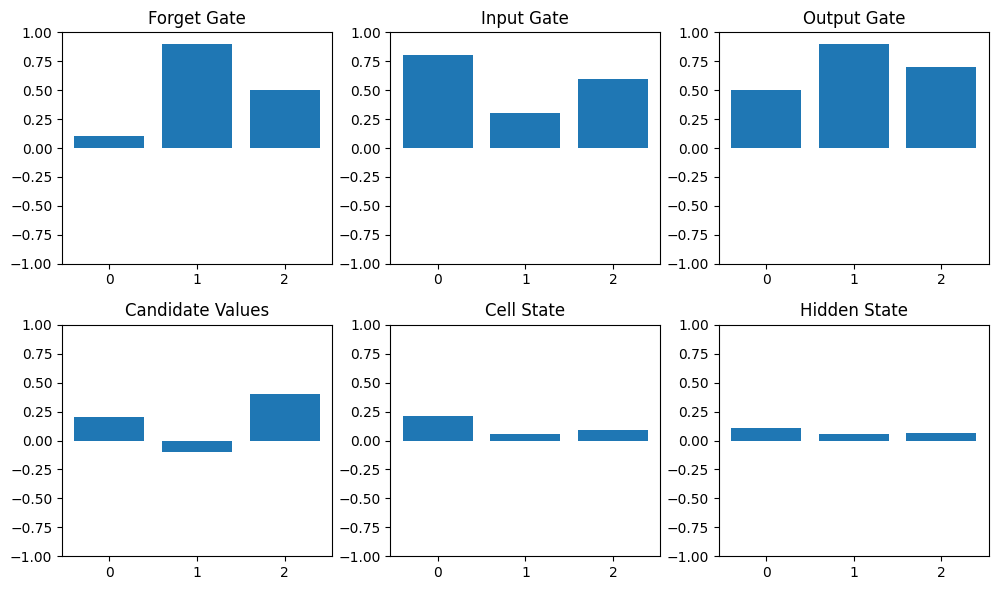

In [4]:
import matplotlib.pyplot as plt

def visualize_gate_operations(forget_gate, input_gate, output_gate, candidate_values, cell_state, hidden_state):
    gates = ["Forget Gate", "Input Gate", "Output Gate", "Candidate Values", "Cell State", "Hidden State"]
    values = [forget_gate, input_gate, output_gate, candidate_values, cell_state, hidden_state]

    plt.figure(figsize=(10, 6))
    for i in range(len(gates)):
        plt.subplot(2, 3, i+1)
        plt.bar(range(len(values[i])), values[i])
        plt.title(gates[i])
        plt.ylim(-1, 1)
    plt.tight_layout()
    plt.show()

# Example gate values
forget_gate = [0.1, 0.9, 0.5]
input_gate = [0.8, 0.3, 0.6]
output_gate = [0.5, 0.9, 0.7]
candidate_values = [0.2, -0.1, 0.4]
cell_state = [0.21, 0.06, 0.09]
hidden_state = [0.105, 0.054, 0.063]

visualize_gate_operations(forget_gate, input_gate, output_gate, candidate_values, cell_state, hidden_state)


# Summary
* Forget Gate: Determines which parts of the previous cell state to forget. For instance, if processing "fox", we may forget details about "The" and "quick".
* Input Gate: Decides what new information to store in the cell state. When processing "fox", we might add the information that "fox" is a noun.
* Output Gate: Determines what part of the cell state to output as the hidden state, which will help in predicting the next word "jumps".